In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
import time
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 支持中文 负号

In [2]:
#定义 字体的颜色等等
font = {
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 20,
        }


In [3]:
def get_data(code_num):
    #获取数据
    df=pd.read_csv("./Desktop/text/300000/"+code_num+".csv")
    df=df.iloc[:,2:7]
    df['trade_date'] = df['trade_date'].map(lambda x:datetime.strptime(str(x),'%Y%m%d'))
    df = df.set_index('trade_date')
    data = df.sort_index()
    data = data[data.index>"2019-02-28"]
    
    return data 

In [4]:
data = get_data("300001")

In [5]:
data.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

In [6]:
def get_KDJ(data):
    # 计算KDJ指标
    low_list = data['low'].rolling(9, min_periods=1).min()
    high_list = data['high'].rolling(9, min_periods=1).max()
    rsv = (data['close'] - low_list) / (high_list - low_list) * 100
    data['K'] = rsv.ewm(com=2).mean()
    data['D'] = data['K'].ewm(com=2).mean()
    data['J'] = 3 * data['K'] - 2 * data['D']
    # 计算KDJ指标金叉、死叉情况
    data['金叉死叉'] = None
    data['金叉'] = None
    data['死叉'] = None

    
    kdj_position = data['K'] > data['D']
    data.loc[kdj_position[(kdj_position == True) & (kdj_position.shift() == False)].index, '金叉死叉'] = '金叉'
    data.loc[kdj_position[(kdj_position == True) & (kdj_position.shift() == False)].index, '金叉'] = data["K"]
    kdj_position = data['K'] < data['D']
    data.loc[kdj_position[(kdj_position == True) & (kdj_position.shift() == False)].index, '金叉死叉'] = '死叉'
    data.loc[kdj_position[(kdj_position == True) & (kdj_position.shift() == False)].index, '死叉'] = data["K"]
    
    # 计算KDJ指标J线情况 
    data['J线研判'] = None
    data["J线买点"]=None
    data["J线卖点"]=None
    
    J_position1 = data['J'] > 0
    J_position2 = data['J'] < 100
    data.loc[J_position1[(J_position1 == True) & (J_position1.shift() == False)].index, 'J线买点'] = data["J"]
    data.loc[J_position1[(J_position1 == True) & (J_position1.shift() == False)].index, 'J线研判'] = '买入'
    data.loc[J_position2[(J_position2 == True) & (J_position2.shift() == False)].index, 'J线卖点'] = data["J"]
    data.loc[J_position1[(J_position2 == True) & (J_position2.shift() == False)].index, 'J线研判'] = '卖出'
    
    # 计算N天后涨跌幅
    for i in [1, 3, 5, 10]:
        data[str(i)+'天后涨跌幅'] = data['close'].shift(-i) / data['close'] - 1


    return data

In [7]:
def output_data(data):
    output = pd.DataFrame()
   
    # 合并数据
    output = output.append(data[data['金叉死叉'].notnull()])
    
    # output.to_csv(config.output_data_path + '/kdj.csv', index=False)

    condition1 = (output['D'] >= 80) & (output['金叉死叉'] == '死叉')
    condition2 = (output['D'] <= 20) & (output['金叉死叉'] == '金叉')
    output = output[condition1 | condition2]


    for t, group in output.groupby('金叉死叉'):
        print(t)
        print(group[[str(i)+'天后涨跌幅' for i in (1, 3, 5, 10)]].describe())  #观察这一系列数据的范围
        for i in 1, 3, 5, 10:
            if t == '金叉':
                print(str(i)+'天后涨跌幅大于0天数', '\t' , float(group[group[str(i) + '天后涨跌幅'] > 0].shape[0]) / group.shape[0])          
                
            elif t == '死叉':
                print(str(i)+'天后涨跌幅小于0天数', '\t' , float(group[group[str(i) + '天后涨跌幅'] < 0].shape[0]) / group.shape[0])
                
    return output
    

In [8]:
def draw_KDJ(data,title):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    dpi = 72.
    xinch = 1200 / dpi
    yinch = 400 / dpi

    data[['K','D',"J"]].plot(figsize=(xinch,yinch))
    plt.scatter(data.index,data["金叉"],s=50,color="red",label="金叉",marker='^',alpha=1)
    plt.xlabel("Trade_date",font)

    plt.scatter(data.index,data["死叉"],s=50,color="black",label="死叉",marker='^',alpha=1)
    
    plt.scatter(data.index,data["J线买点"],s=50,color="lime",label="J线买点",marker='p',alpha=1)
    plt.scatter(data.index,data["J线卖点"],s=50,color="hotpink",label="J线卖点",marker='p',alpha=1)
    
    
    plt.title(title+"KDJ指标可视化",fontdict=font)
    plt.grid()
    
    plt.tick_params(labelsize=16)  #刻度大小
    plt.legend(loc='best')

    plt.show()

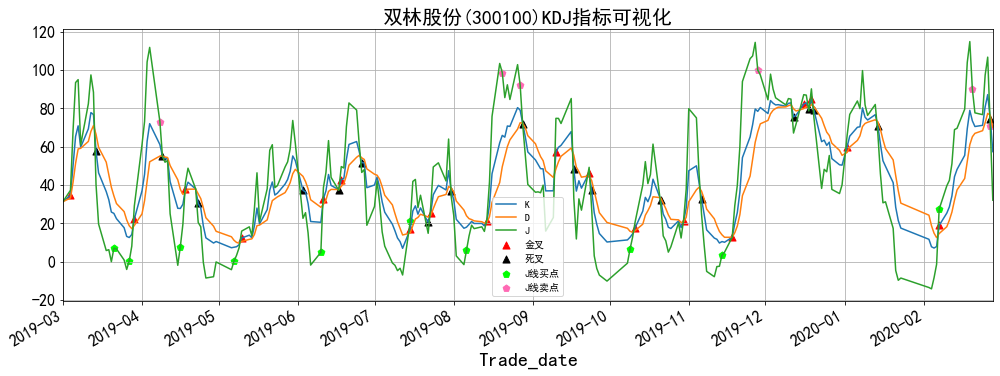

死叉
         1天后涨跌幅    3天后涨跌幅    5天后涨跌幅   10天后涨跌幅
count  2.000000  2.000000  2.000000  2.000000
mean  -0.002391 -0.010873 -0.003306  0.015051
std    0.031856  0.005979  0.009420  0.007189
min   -0.024917 -0.015101 -0.009967  0.009967
25%   -0.013654 -0.012987 -0.006636  0.012509
50%   -0.002391 -0.010873 -0.003306  0.015051
75%    0.008871 -0.008759  0.000025  0.017592
max    0.020134 -0.006645  0.003356  0.020134
1天后涨跌幅小于0天数 	 0.5
3天后涨跌幅小于0天数 	 1.0
5天后涨跌幅小于0天数 	 0.5
10天后涨跌幅小于0天数 	 0.0
金叉
         1天后涨跌幅    3天后涨跌幅    5天后涨跌幅   10天后涨跌幅
count  6.000000  6.000000  6.000000  6.000000
mean   0.007570  0.003777 -0.009275  0.003893
std    0.018776  0.035045  0.045666  0.060142
min   -0.016588 -0.034868 -0.060427 -0.053318
25%   -0.008738 -0.018990 -0.049348 -0.034713
50%    0.014484 -0.004457 -0.008944 -0.019865
75%    0.022363  0.022021  0.026763  0.037627
max    0.024528  0.059434  0.046816  0.099278
1天后涨跌幅大于0天数 	 0.6666666666666666
3天后涨跌幅大于0天数 	 0.3333333333333333
5天后涨跌幅大于0天数 	 0.5
10天后涨跌幅大于

In [9]:
data = get_data("300100")
data_kdj=get_KDJ(data)
draw_KDJ(data_kdj,"双林股份(300100)")
output = output_data(data_kdj)

In [12]:
columns_1=["1天后涨跌幅","3天后涨跌幅","5天后涨跌幅","10天后涨跌幅"]

In [13]:
data_kdj.drop(columns = columns_1)

,open,high,low,close,K,D,J,金叉死叉,金叉,死叉,J线研判,J线买点,J线卖点
trade_date,,,,,,,,,,,,,
2019-03-01,10.70,10.88,10.40,10.55,31.250000,31.250000,31.250000,None,None,None,None,None,None
2019-03-04,10.69,10.97,10.50,10.61,34.605263,33.263158,37.289474,金叉,34.6053,None,None,None,None
2019-03-05,10.53,11.67,10.50,11.26,50.289550,41.328291,68.212068,None,None,None,None,None,None
2019-03-06,11.20,11.51,11.00,11.50,65.378240,51.318270,93.498180,None,None,None,None,None,None
2019-03-07,11.34,11.98,11.20,11.66,70.894146,58.833180,95.016079,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,6.02,6.34,5.95,6.18,71.171325,68.381106,76.751762,None,None,None,None,None,None
2020-02-25,6.10,6.80,6.05,6.80,80.780883,72.514365,97.313919,None,None,None,None,None,None
2020-02-26,7.48,7.48,7.48,7.48,87.187255,77.405329,106.751109,None,None,None,None,None,None


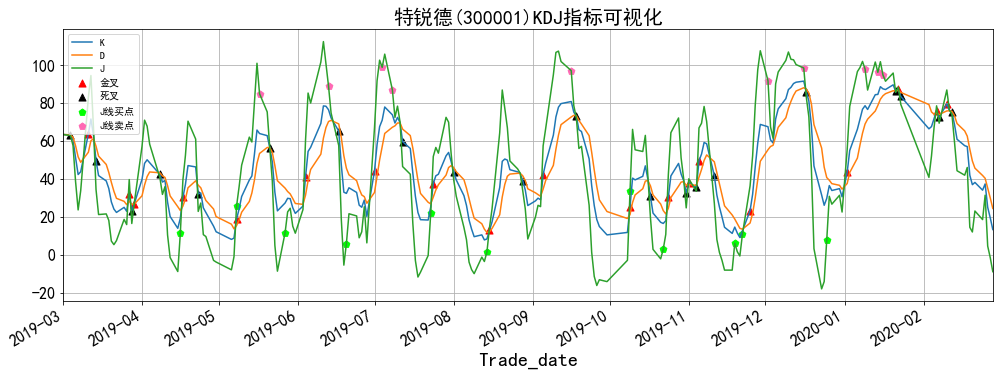

死叉
         1天后涨跌幅    3天后涨跌幅    5天后涨跌幅   10天后涨跌幅
count  3.000000  3.000000  3.000000  3.000000
mean  -0.010256 -0.010436  0.026805  0.015834
std    0.085412  0.045380  0.088061  0.088391
min   -0.099880 -0.037726 -0.059595 -0.060689
25%   -0.050487 -0.036628 -0.018012 -0.032542
50%   -0.001093 -0.035531  0.023572 -0.004395
75%    0.034556  0.003209  0.070005  0.054095
max    0.070205  0.041950  0.116438  0.112586
1天后涨跌幅小于0天数 	 0.6666666666666666
3天后涨跌幅小于0天数 	 0.6666666666666666
5天后涨跌幅小于0天数 	 0.3333333333333333
10天后涨跌幅小于0天数 	 0.6666666666666666
金叉
         1天后涨跌幅    3天后涨跌幅    5天后涨跌幅   10天后涨跌幅
count  3.000000  3.000000  3.000000  3.000000
mean  -0.009471  0.025731  0.012845  0.038049
std    0.003680  0.002425  0.008006  0.092470
min   -0.012247  0.023018  0.006474 -0.022366
25%   -0.011558  0.024752  0.008352 -0.015177
50%   -0.010870  0.026486  0.010230 -0.007987
75%   -0.008083  0.027088  0.016031  0.068257
max   -0.005297  0.027689  0.021832  0.144501
1天后涨跌幅大于0天数 	 0.0
3天后涨跌幅大于0天数 	 1

In [17]:
data = get_data("300001")
data_kdj=get_KDJ(data)
draw_KDJ(data_kdj,"特锐德(300001)")
output = output_data(data_kdj)

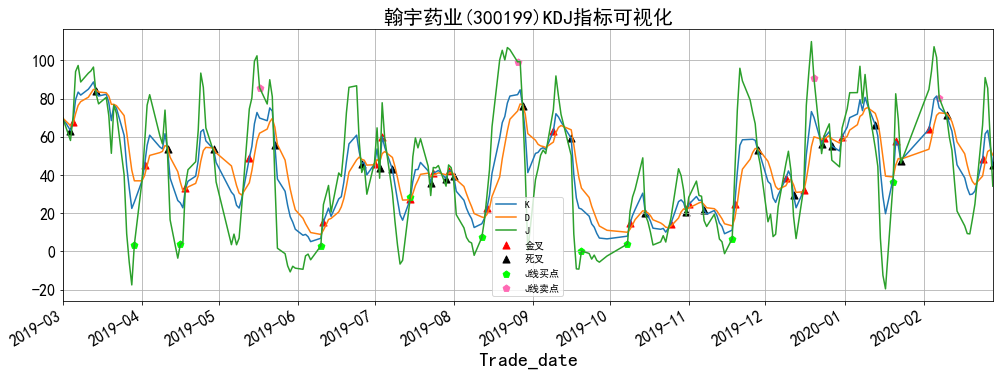

死叉
         1天后涨跌幅    3天后涨跌幅    5天后涨跌幅   10天后涨跌幅
count  1.000000  1.000000  1.000000  1.000000
mean   0.008985  0.002695  0.049416 -0.079964
std         NaN       NaN       NaN       NaN
min    0.008985  0.002695  0.049416 -0.079964
25%    0.008985  0.002695  0.049416 -0.079964
50%    0.008985  0.002695  0.049416 -0.079964
75%    0.008985  0.002695  0.049416 -0.079964
max    0.008985  0.002695  0.049416 -0.079964
1天后涨跌幅小于0天数 	 0.0
3天后涨跌幅小于0天数 	 0.0
5天后涨跌幅小于0天数 	 0.0
10天后涨跌幅小于0天数 	 1.0
金叉
         1天后涨跌幅    3天后涨跌幅    5天后涨跌幅   10天后涨跌幅
count  5.000000  5.000000  5.000000  5.000000
mean   0.004658  0.003104 -0.027105 -0.041375
std    0.014854  0.040314  0.077872  0.094980
min   -0.016967 -0.046660 -0.152909 -0.192152
25%   -0.004060 -0.016447 -0.036055 -0.039474
50%    0.011827  0.006766 -0.006579 -0.028632
75%    0.013158  0.008787  0.003515 -0.017575
max    0.019332  0.063075  0.056505  0.070959
1天后涨跌幅大于0天数 	 0.6
3天后涨跌幅大于0天数 	 0.6
5天后涨跌幅大于0天数 	 0.4
10天后涨跌幅大于0天数 	 0.2


In [15]:
data = get_data("300199")
data_kdj=get_KDJ(data)
draw_KDJ(data_kdj,"翰宇药业(300199)")
output = output_data(data_kdj)

In [42]:
data

,open,high,low,close,K,D,J,金叉死叉,金叉,死叉,J线研判,J线买点,J线卖点,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,,,,,,
2019-03-01,9.81,9.81,9.38,9.68,69.767442,69.767442,69.767442,None,None,None,None,None,None,0.037190,0.079545,0.078512,0.160124
2019-03-04,9.70,10.50,9.68,10.04,63.264120,65.865449,58.061462,死叉,None,63.2641,None,None,None,0.015936,0.038845,0.114542,0.133466
2019-03-05,9.93,10.20,9.93,10.20,67.977356,66.865826,70.200417,金叉,67.9774,None,None,None,None,0.024510,0.023529,0.096078,0.094118
2019-03-06,10.26,10.48,10.07,10.45,79.424674,72.082578,94.108866,None,None,None,None,None,None,-0.001914,0.070813,0.076555,0.039234
2019-03-07,10.50,10.55,10.25,10.43,83.385964,76.421793,97.314307,None,None,None,None,None,None,0.000959,0.071908,0.067114,0.119847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,6.53,6.73,6.53,6.69,48.330745,39.435557,66.121121,金叉,48.3307,None,None,None,None,0.052317,-0.004484,NaN,NaN
2020-02-25,6.65,7.15,6.58,7.04,61.524526,46.798547,90.976484,None,None,None,None,None,None,-0.026989,-0.076705,NaN,NaN
2020-02-26,6.90,7.13,6.77,6.85,63.360673,52.319255,85.443508,None,None,None,None,None,None,-0.027737,NaN,NaN,NaN


In [40]:
output=output.drop(columns=["J线卖点","金叉","死叉","J线研判","J线买点"])

NameError: name 'output' is not defined

In [21]:
output

,open,high,low,close,K,D,J,金叉死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,
2015-04-14,28.81,29.60,27.12,28.75,62.161650,80.834229,24.816492,死叉,-0.099826,-0.053913,-0.048348,0.234783
2015-06-15,49.50,49.57,47.00,47.00,80.086508,83.537731,73.184061,死叉,-0.056170,-0.065532,-0.242979,-0.512979
2015-07-13,27.70,27.70,26.00,27.70,13.508145,11.651560,17.221315,金叉,0.072202,-0.109025,0.010830,-0.057040
2015-08-31,18.12,18.84,17.62,17.85,18.524047,16.460816,22.650507,金叉,-0.099720,-0.103641,0.052101,-0.050980
2015-09-07,16.20,17.23,15.95,16.00,19.045409,17.483118,22.169992,金叉,0.090625,0.171250,0.070625,0.143750
2015-11-13,27.10,27.50,25.61,26.40,80.355735,82.704403,75.658397,死叉,0.040530,-0.050379,-0.025379,0.024621
2016-01-14,15.52,17.60,15.42,17.53,12.247335,11.863740,13.014524,金叉,-0.042213,0.052481,-0.018825,-0.151740
2016-02-23,18.73,18.99,17.78,18.15,81.840505,83.076951,79.367612,死叉,-0.023691,-0.121763,-0.169146,-0.064463
2016-12-01,19.87,20.08,19.87,20.05,20.158011,19.336443,21.801149,金叉,-0.031421,-0.049875,-0.047382,-0.120698


In [40]:

data_100 =get_KDJ(get_data("300100.csv")).drop(columns=["J线卖点","金叉","死叉","J线研判","J线买点"])
data_001 =get_KDJ(get_data("300001.csv")).drop(columns=["J线卖点","金叉","死叉","J线研判","J线买点"])
data_199=get_KDJ(get_data("300199.csv")).drop(columns=["J线卖点","金叉","死叉","J线研判","J线买点"])



In [41]:
data_001

,open,high,low,close,K,D,J,金叉死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,
2015-01-05,18.52,20.45,17.36,19.53,70.226537,70.226537,70.226537,None,0.031746,-0.011265,-0.000512,0.011265
2015-01-06,19.19,20.57,18.98,20.15,80.240148,76.234703,88.251036,金叉,-0.028784,-0.041687,-0.030769,0.029777
2015-01-07,20.14,20.30,19.33,19.57,74.843560,75.575741,73.379199,死叉,-0.013286,-0.002555,0.010731,0.070005
2015-01-08,19.54,19.90,19.30,19.31,68.988342,72.839437,61.286152,None,0.000000,0.011393,0.027447,0.099948
2015-01-09,19.29,19.75,19.24,19.31,65.824859,70.146636,57.181303,None,0.010875,0.024340,0.055930,0.064215
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-10,25.22,27.02,25.21,26.96,79.518009,75.829812,86.894402,金叉,-0.043027,-0.066024,-0.037463,-0.075297
2020-02-11,26.81,27.15,25.75,25.80,76.056403,75.905342,76.358525,None,0.007364,-0.034109,0.008915,-0.031008
2020-02-12,25.58,26.49,25.50,25.99,75.087637,75.632774,73.997364,死叉,-0.031166,-0.001539,-0.041939,-0.103886


In [7]:
def get_data_all(code_num):
    #获取数据
    df=pd.read_csv(code_num)
    df=df.iloc[:,1:6]
    df['trade_date'] = df['trade_date'].map(lambda x:datetime.strptime(str(x),'%Y%m%d'))
    df = df.set_index('trade_date')
    data = df.sort_index()
 
    return data 

In [8]:
df_b = pd.DataFrame()
for  i in range (1,500): 
    code = str(300000+i)
    data=get_data_all("./Desktop/text/"+code+".SZ.csv")
    data_1 =get_KDJ(data).drop(columns=["J线卖点","金叉","死叉","J线研判","J线买点"])
    df_b = pd.concat([df_b, data_1])
    

In [9]:
df_b

,open,high,low,close,K,D,J,金叉死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,
2009-10-30,42.00,64.00,35.01,44.00,31.010693,31.010693,31.010693,None,-0.100000,-0.135909,-0.115682,-0.073636
2009-11-02,39.60,41.87,39.60,39.60,21.904105,25.546740,14.618834,死叉,-0.068182,0.000000,-0.003030,0.035354
2009-11-03,38.20,39.36,36.15,36.90,14.616655,20.369332,3.111303,None,0.030352,0.054472,0.028997,0.108401
2009-11-04,38.00,38.90,37.23,38.02,12.858015,17.249246,4.075552,None,0.041557,0.038401,0.005260,0.126775
2009-11-05,38.03,40.98,37.51,39.60,14.000088,16.001939,9.996387,None,-0.017424,-0.041162,-0.026263,0.134091
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-11,11.22,11.30,11.14,11.27,50.304381,47.728339,55.456467,None,-0.017746,0.010648,0.038154,0.033718
2019-12-12,11.20,11.26,11.06,11.07,36.804228,44.086968,22.238747,死叉,0.009033,0.041554,0.079494,0.051491
2019-12-13,11.16,11.27,11.05,11.17,34.340074,40.838004,21.344214,None,0.019696,0.047449,0.056401,0.023277


In [11]:
df_b_output = output_data(df_b)

死叉
            1天后涨跌幅       3天后涨跌幅       5天后涨跌幅      10天后涨跌幅
count  8925.000000  8925.000000  8925.000000  8925.000000
mean      0.001532     0.005470     0.009975     0.014512
std       0.046432     0.086060     0.112170     0.158308
min      -0.700000    -0.730011    -0.745128    -0.757126
25%      -0.019190    -0.031575    -0.037198    -0.052680
50%       0.002421     0.003398     0.008610     0.013947
75%       0.022164     0.044456     0.060241     0.086256
max       0.101449     0.333333     0.610798     1.587294
1天后涨跌幅小于0天数 	 0.4565826330532213
3天后涨跌幅小于0天数 	 0.47103641456582634
5天后涨跌幅小于0天数 	 0.44829131652661064
10天后涨跌幅小于0天数 	 0.4425770308123249
金叉
             1天后涨跌幅        3天后涨跌幅        5天后涨跌幅       10天后涨跌幅
count  13610.000000  13610.000000  13610.000000  13610.000000
mean       0.003809      0.006718     -0.000611     -0.000150
std        0.036225      0.070208      0.085897      0.126708
min       -0.597590     -0.639844     -0.688804     -0.790880
25%       -0.013548     -0.

In [10]:
df_a = pd.DataFrame()
for  i in range (500,1000): 
    code = str(300000+i)
    data=get_data_all("./Desktop/text/"+code+".SZ.csv")
    data_1 =get_KDJ(data).drop(columns=["J线卖点","金叉","死叉","J线研判","J线买点"])
    df_a = pd.concat([df_a, data_1])
    

In [12]:
df_a

,open,high,low,close,K,D,J,金叉死叉,1天后涨跌幅,3天后涨跌幅,5天后涨跌幅,10天后涨跌幅
trade_date,,,,,,,,,,,,
2016-02-04,27.60,30.11,27.60,30.11,100.0,100.0,100.0,None,0.099967,0.330787,0.610428,1.593491
2016-02-05,33.12,33.12,33.12,33.12,100.0,100.0,100.0,None,0.099940,0.330918,0.610507,1.279589
2016-02-15,36.43,36.43,36.43,36.43,100.0,100.0,100.0,None,0.099918,0.331046,0.610486,0.865221
2016-02-16,40.07,40.07,40.07,40.07,100.0,100.0,100.0,None,0.100075,0.331170,0.610681,0.602196
2016-02-17,44.08,44.08,44.08,44.08,100.0,100.0,100.0,None,0.100045,0.330989,0.610481,0.514065
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-11,47.15,47.15,47.15,47.15,100.0,100.0,100.0,None,0.100106,0.331283,0.611029,0.800000
2019-12-12,51.87,51.87,51.87,51.87,100.0,100.0,100.0,None,0.100058,0.331213,0.610950,0.598419
2019-12-13,57.06,57.06,57.06,57.06,100.0,100.0,100.0,None,0.100070,0.331230,0.610936,0.445496


In [13]:
df_a_output = output_data(df_a)

死叉
            1天后涨跌幅       3天后涨跌幅       5天后涨跌幅      10天后涨跌幅
count  1450.000000  1450.000000  1450.000000  1450.000000
mean     -0.003373    -0.005630    -0.004579    -0.004514
std       0.053188     0.087519     0.110613     0.156145
min      -0.565522    -0.750046    -0.778462    -0.796211
25%      -0.026133    -0.047009    -0.056503    -0.083485
50%       0.000253    -0.002830    -0.004681    -0.005494
75%       0.021750     0.036251     0.049015     0.073676
max       0.100356     0.331163     0.610648     1.548718
1天后涨跌幅小于0天数 	 0.4910344827586207
3天后涨跌幅小于0天数 	 0.5227586206896552
5天后涨跌幅小于0天数 	 0.5227586206896552
10天后涨跌幅小于0天数 	 0.5206896551724138
金叉
            1天后涨跌幅       3天后涨跌幅       5天后涨跌幅      10天后涨跌幅
count  2966.000000  2966.000000  2966.000000  2966.000000
mean     -0.000204     0.001593     0.001279     0.003244
std       0.030523     0.055799     0.071260     0.100434
min      -0.100131    -0.726509    -0.722881    -0.648027
25%      -0.015973    -0.023811    -0.034342    -

In [20]:
df_all = pd.concat([df_a,df_b])
df_all_output = output_data(df_all)

死叉
             1天后涨跌幅        3天后涨跌幅        5天后涨跌幅       10天后涨跌幅
count  10375.000000  10375.000000  10375.000000  10375.000000
mean       0.000846      0.003918      0.007941      0.011853
std        0.047462      0.086347      0.112062      0.158138
min       -0.700000     -0.750046     -0.778462     -0.796211
25%       -0.020000     -0.033684     -0.039667     -0.057072
50%        0.002092      0.002530      0.006919      0.010976
75%        0.022096      0.043327      0.058650      0.084298
max        0.101449      0.333333      0.610798      1.587294
1天后涨跌幅小于0天数 	 0.4613975903614458
3天后涨跌幅小于0天数 	 0.4782650602409639
5天后涨跌幅小于0天数 	 0.4586987951807229
10天后涨跌幅小于0天数 	 0.45349397590361445
金叉
             1天后涨跌幅        3天后涨跌幅        5天后涨跌幅       10天后涨跌幅
count  16576.000000  16576.000000  16576.000000  16576.000000
mean       0.003091      0.005801     -0.000273      0.000457
std        0.035305      0.067882      0.083468      0.122426
min       -0.597590     -0.726509     -0.722881     -0

In [19]:
df_all_output

NameError: name 'df_all_output' is not defined